In [1]:
import sys
sys.path.append('../')

In [2]:
import torchxrayvision as xrv
# from torchxrayvision.datasets import COVID19_Dataset
from src.xrayvision import COVID19_Dataset
import torchvision

import torch
import pandas as pd

from tqdm.auto import tqdm, trange
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline

random.seed(19)
np.random.seed(19)
torch.manual_seed(19)

In [3]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, roc_auc_score, plot_confusion_matrix, plot_roc_curve

In [4]:
from src.visualization import show_images

In [5]:
EXPORT = True

In [6]:
model = xrv.models.DenseNet(weights='all') # CheXpert (Stanford)
model = model.eval()

transform = torchvision.transforms.Compose([xrv.datasets.XRayCenterCrop(),xrv.datasets.XRayResizer(224)])

d_covid19 = COVID19_Dataset(
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/images',
    '/Users/aniket/Google Drive/Projects/covid-research/data/covid-chestxray-dataset/metadata.csv',
    transform=transform
)

In [7]:
data_dict = {'Aspergillosis': {0.0: 534, 1.0: 1},
 'Aspiration': {0.0: 534, 1.0: 1},
 'Bacterial': {0.0: 487, 1.0: 48},
 'COVID-19': {0.0: 193, 1.0: 342},
 'Chlamydophila': {0.0: 534, 1.0: 1},
 'Fungal': {0.0: 512, 1.0: 23},
 'H1N1': {0.0: 534, 1.0: 1},
 'Herpes ': {0.0: 532, 1.0: 3},
 'Influenza': {0.0: 531, 1.0: 4},
 'Klebsiella': {0.0: 526, 1.0: 9},
 'Legionella': {0.0: 526, 1.0: 9},
 'Lipoid': {0.0: 527, 1.0: 8},
 'MERS-CoV': {0.0: 527, 1.0: 8},
 'MRSA': {0.0: 534, 1.0: 1},
 'Mycoplasma': {0.0: 530, 1.0: 5},
 'No Finding': {0.0: 520, 1.0: 15},
 'Nocardia': {0.0: 531, 1.0: 4},
 'Pneumocystis': {0.0: 513, 1.0: 22},
 'Pneumonia': {0.0: 26, 1.0: 509},
 'SARS': {0.0: 519, 1.0: 16},
 'Staphylococcus': {0.0: 534, 1.0: 1},
 'Streptococcus': {0.0: 518, 1.0: 17},
 'Tuberculosis': {0.0: 524, 1.0: 11},
 'Varicella': {0.0: 530, 1.0: 5},
 'Viral': {0.0: 157, 1.0: 378}}
table = pd.DataFrame.from_dict(data_dict);table

,Aspergillosis,Aspiration,Bacterial,COVID-19,Chlamydophila,Fungal,H1N1,Herpes,Influenza,Klebsiella,...,No Finding,Nocardia,Pneumocystis,Pneumonia,SARS,Staphylococcus,Streptococcus,Tuberculosis,Varicella,Viral
0.0,534,534,487,193,534,512,534,532,531,526,...,520,531,513,26,519,534,518,524,530,157
1.0,1,1,48,342,1,23,1,3,4,9,...,15,4,22,509,16,1,17,11,5,378


In [8]:
np.isnan(d_covid19[56]['intubated'])

True

In [9]:
d_covid19[random.randint(0, len(d_covid19))]

{'idx': 335,
 'lab': array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 1.], dtype=float32),
 'intubated': nan,
 'img': array([[[-532.6877 , -583.04865, -580.68427, ..., -576.04205,
          -577.40686, -531.8482 ],
         [-763.0932 , -814.43933, -817.7728 , ..., -831.5728 ,
          -832.1598 , -766.07825],
         [-769.4719 , -850.18835, -862.8646 , ..., -831.8141 ,
          -788.3016 , -713.03986],
         ...,
         [ 297.77124,  377.56723,  395.23657, ...,  223.7607 ,
           274.84937,  180.15999],
         [ 329.36517,  415.6304 ,  374.44904, ...,  207.21921,
           212.50743,  244.61526],
         [ 408.73993,  400.93616,  363.7805 , ...,  236.09398,
           207.90071,  281.96735]]], dtype=float32)}

# predict whether intubation required in case of any chest problem
## Create features

In [10]:
images = []
intubation_labels = []
for i in trange(len(d_covid19)):
    sample = d_covid19[i]
    image = sample['img']
    intubated = sample['intubated']
    
    if intubated in ('Y', 'N'):
        images.append(image)
        intubation_labels.append(intubated)
#     if i > 50:
#         break

## generated image embeddings

In [11]:
with torch.no_grad():
    X = []

    avg_pool = torch.nn.AvgPool2d((7, 7))
    for image in tqdm(images):
        image = torch.from_numpy(image)
        image = image.expand(1, 1, 224, 224)
        features = model.features(image)
        #print(features.shape)
        features = avg_pool(features)
        #print(features.shape)
        X.append(features.numpy().reshape(1024))
    X = np.asarray(X)

In [12]:
label_map = {'Y': 1, 'N': 0}
Y = np.asarray([[label_map[e]] for e in intubation_labels])

## Split train test

In [13]:
data = {}
split_pct = 0.75
total = len(X)
idx = list(range(len(X)))
random.shuffle(idx)

train_idx = idx[:int(total*split_pct)]
test_idx = idx[int(total*split_pct):]

data['train'] = X[train_idx], Y[train_idx]
data['test'] = X[test_idx], Y[test_idx]

data['info'] = {
    'train': {   
        'train_count': len(train_idx),
        'train_pos': np.sum(Y[train_idx]==1),
        'train_neg': np.sum(Y[train_idx]==0)   
    },
    'test': {
        'test_count': len(test_idx),
        'test_pos': np.sum(Y[test_idx]==1),
        'test_neg': np.sum(Y[test_idx]==0),   
    }
}

In [14]:
data['info']

{'train': {'train_count': 119, 'train_pos': 60, 'train_neg': 59},
 'test': {'test_count': 40, 'test_pos': 26, 'test_neg': 14}}

## Train models

In [15]:
knn = KNeighborsClassifier(5)
knn.fit(*data['train'])
knn.score(*data['train']), knn.score(*data['test'])

(0.8151260504201681, 0.75)

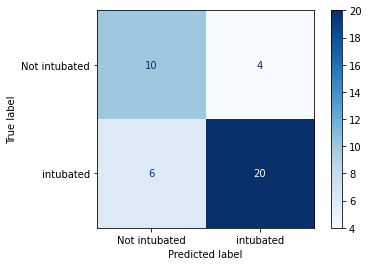

In [21]:
plot_confusion_matrix(
    knn,
    data['test'][0],
    data['test'][1],
    labels=(0, 1),
    display_labels = ('Not intubated', 'intubated'),
    cmap=plt.cm.Blues
)
if EXPORT:
    plt.savefig('../images/intubation_cmat.svg')
plt.show()

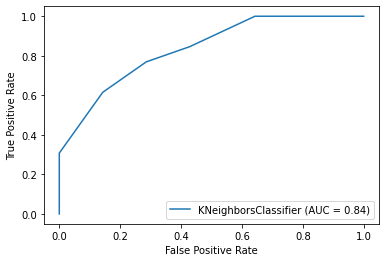

In [20]:
plot_roc_curve(
    knn,
    *data['test']

)
if EXPORT:
    plt.savefig('../images/intubation-roc-curve.png')
plt.show()